In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image
import os


In [2]:
# === PARAMETERS ===
IMG_SIZE = 224  # MobileNetV2 default
BATCH_SIZE = 32
EPOCHS = 10
train_dir = r'D:\Graduation project\id_data_split\train'
val_dir = r'D:\Graduation project\id_data_split\val'


In [3]:
# === DATA AUGMENTATION ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [4]:
# === LOAD DATA ===
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for ROC
)


Found 3856 images belonging to 2 classes.
Found 964 images belonging to 2 classes.


In [5]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# === TRAIN MODEL ===
model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

# Unfreeze the top layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-40]:  # Freeze all except last 40 layers
    layer.trainable = False

# Recompile with lower LR
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continue training
fine_tune_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# === SAVE MODEL ===
model.save(r"D:\Graduation project\mobilenet_id_classifier.h5")


C:\Users\muham\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.7943 - loss: 0.4247 - val_accuracy: 0.9876 - val_loss: 0.0577
Epoch 2/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 89s 731ms/step - accuracy: 0.9814 - loss: 0.0831 - val_accuracy: 0.9907 - val_loss: 0.0305
Epoch 3/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 92s 759ms/step - accuracy: 0.9840 - loss: 0.0502 - val_accuracy: 0.9938 - val_loss: 0.0200
Epoch 4/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 90s 746ms/step - accuracy: 0.9923 - loss: 0.0338 - val_accuracy: 0.9948 - val_loss: 0.0161
Epoch 5/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 91s 750ms/step - accuracy: 0.9932 - loss: 0.0284 - val_accuracy: 0.9948 - val_loss: 0.0128
Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 113s 853ms/step - accuracy: 0.6996 - loss: 1.1109 - val_accuracy: 0.9907 - val_loss: 0.0202
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 103s 855ms/step - accuracy: 0.9791 - loss: 0.0603 - val_accuracy: 0.9927 - val_loss: 0.0189
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 101s 832ms/step - accuracy: 0.9937 - loss: 0.027

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step


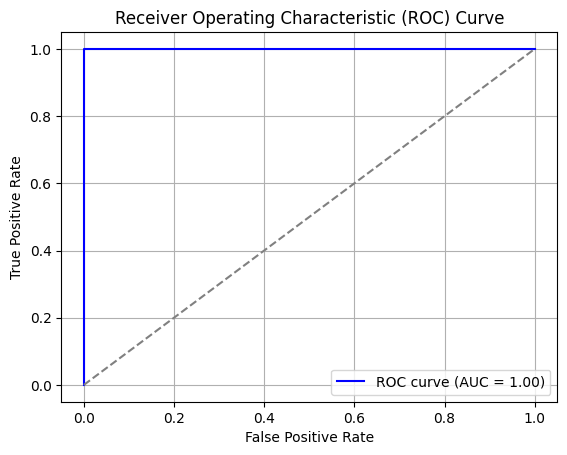

In [8]:
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step


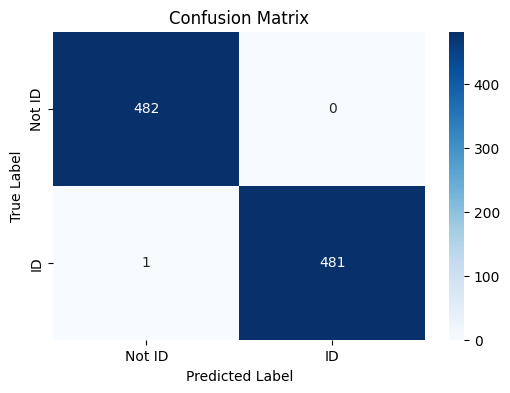

Classification Report:

              precision    recall  f1-score   support

      Not ID       1.00      1.00      1.00       482
          ID       1.00      1.00      1.00       482

    accuracy                           1.00       964
   macro avg       1.00      1.00      1.00       964
weighted avg       1.00      1.00      1.00       964



In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === Predict on Validation Data ===
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# === True Labels ===
y_true = val_generator.classes

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not ID", "ID"],
            yticklabels=["Not ID", "ID"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# === Classification Report ===
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Not ID", "ID"]))


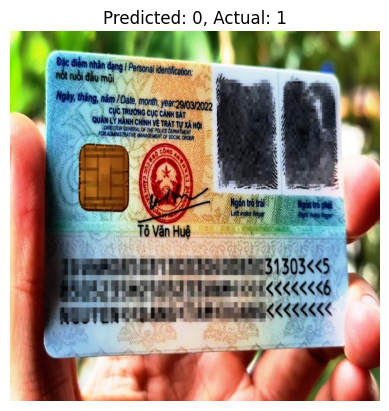

In [14]:
# Get filenames and the predicted/true labels
filenames = val_generator.filenames
misclassified_idx = np.where(y_true != y_pred)[0]

# Display the misclassified image
from tensorflow.keras.preprocessing import image
img_path = val_generator.filepaths[misclassified_idx[0]]
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Predicted: {y_pred[misclassified_idx[0]]}, Actual: {y_true[misclassified_idx[0]]}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


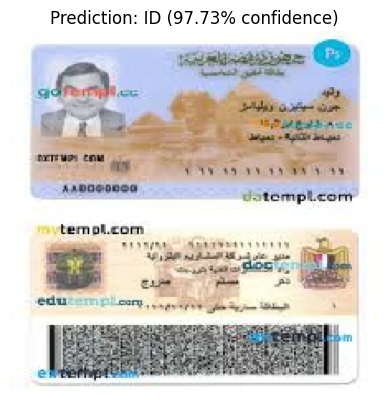

('ID', 0.9772566817700863)

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model(r"D:\Graduation project\mobilenet_id_classifier.h5")  # Replace with your actual path

# Function to load and preprocess a single image
def predict_image(img_path):
    # Load image and resize to match model's input shape
    img = image.load_img(img_path, target_size=(224, 224))  # Match your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize if model was trained this way

    # Predict
    prediction = model.predict(img_array)

    # Interpret result
    predicted_class = "ID" if prediction[0][0] < 0.5 else "Not ID"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    # Display
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2%} confidence)")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Example usage
img_path = r'D:\download.jpg'  # Replace this with your test image path
predict_image(img_path)


In [21]:
print(val_generator.class_indices)


{'id': 0, 'not_id': 1}
